In [32]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData

import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

import os
import subprocess
from spatialdata_io import xenium, visium_hd
import spatialdata as sd
import spatialdata_plot

import matplotlib.pyplot as plt
from spatialdata import bounding_box_query

from pathlib import Path
import shutil

import requests
import gzip
import pandas as pd
from pathlib import Path
import os

try:
    import squidpy as sq
except ImportError:
    import subprocess

    subprocess.check_call(["uv", "pip", "install", "squidpy"])
    import squidpy as sq
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# load xenium data

In [34]:
subprocess.run(
    f"unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/",
    shell=True,
    check=True,
)

Archive:  ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip
  inflating: ../data/xenium/analysis_summary.html  
 extracting: ../data/xenium/analysis.zarr.zip  
  inflating: ../data/xenium/cell_boundaries.csv.gz  
  inflating: ../data/xenium/cell_boundaries.parquet  
  inflating: ../data/xenium/cell_feature_matrix.h5  
 extracting: ../data/xenium/cell_feature_matrix.zarr.zip  
  inflating: ../data/xenium/cells.csv.gz  
  inflating: ../data/xenium/cells.parquet  
 extracting: ../data/xenium/cells.zarr.zip  
  inflating: ../data/xenium/experiment.xenium  
  inflating: ../data/xenium/gene_panel.json  
  inflating: ../data/xenium/metrics_summary.csv  
   creating: ../data/xenium/morphology_focus/
  inflating: ../data/xenium/morphology_focus/morphology_focus_0000.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_0001.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_0002.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_000

CompletedProcess(args='unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/', returncode=0)

In [ ]:
# from https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-skin
urls = [
    "https://cf.10xgenomics.com/samples/xenium/3.0.0/Xenium_Prime_Human_Skin_FFPE/Xenium_Prime_Human_Skin_FFPE_outs.zip"
]

# download the data
for url in urls:
    filename = Path(url).name
    os.makedirs("../data/xenium", exist_ok=True)
    command = f"curl -o {'../data/xenium/' + filename} {url}"
    subprocess.run(command, shell=True, check=True)

# unzip the data
subprocess.run(
    f"unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/",
    shell=True,
    check=True,
)

In [2]:
path_write = Path("../data/xenium/data.zarr")

In [3]:
path_read = "../data/xenium/"

if path_write.exists():
    sdata = sd.read_zarr(path_write)
    print(sdata)
else:
    print("parsing the data... ", end="")
    sdata = xenium(
        path=str(path_read),
        n_jobs=8,
        cell_boundaries=True,
        nucleus_boundaries=True,
        morphology_focus=True,
        cells_as_circles=True,
    )
    print("done")

    print("writing the data... ", end="")
    if path_write.exists():
        shutil.rmtree(path_write)
    sdata.write(path_write)
    print("done")

Tue Aug  5 16:49:28 2025 WARNING version mismatch: detected: RasterFormatV02, requested: FormatV04
Tue Aug  5 16:49:28 2025 INFO root_attr: multiscales
Tue Aug  5 16:49:28 2025 INFO root_attr: omero
Tue Aug  5 16:49:28 2025 INFO root_attr: spatialdata_attrs
Tue Aug  5 16:49:28 2025 INFO datasets [{'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [1.0, 2.0, 2.0], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [1.0, 4.000394244037059, 4.0], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [1.0, 8.00236593059937, 8.00074864308441], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [1.0, 16.00473186119874, 16.004492699363535], 'type': 'scale'}], 'path': '4'}]
Tue Aug  5 16:49:28 2025 INFO resolution: 0
Tue Aug  5 16:49:28 2025 INFO  - shape ('c', 'y', 'x') = (4, 20294, 42748)
Tue Aug  5 16:49:28 2025 INFO  - chunks =  ['1', '4096 (+ 3

SpatialData object, with associated Zarr store: /home/ml4ig1/Documents code/scPRINT/notebooks/data/xenium/data.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 20294, 42748), (4, 10147, 21374), (4, 5073, 10687), (4, 2536, 5343), (4, 1268, 2671)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (20294, 42748), (10147, 21374), (5073, 10687), (2536, 5343), (1268, 2671)
│     └── 'nucleus_labels': DataTree[yx] (20294, 42748), (10147, 21374), (5073, 10687), (2536, 5343), (1268, 2671)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (112551, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (112551, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (109795, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (112551, 5006)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labe

In [4]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 112551 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [5]:
def crop1(x):
    return bounding_box_query(
        x,
        min_coordinate=[30_000, 2500],
        max_coordinate=[40_000, 12700],
        axes=("x", "y"),
        target_coordinate_system="global",
    )


def crop0(x):
    return bounding_box_query(
        x,
        min_coordinate=[20_000, 8000],
        max_coordinate=[22_000, 8500],
        axes=("x", "y"),
        target_coordinate_system="global",
    )


sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

In [6]:
sdata.tables["table"].raw = sdata.tables["table"].copy()
sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")

gene_ids    feature_types   genome  highly_variable     means  \
CYP2A6  ENSG00000255974  Gene Expression  Unknown            False  0.000013   
UPK2    ENSG00000110375  Gene Expression  Unknown            False  0.000082   
F2      ENSG00000180210  Gene Expression  Unknown            False  0.000088   
EIF1AY  ENSG00000198692  Gene Expression  Unknown            False  0.000102   
CTNND2  ENSG00000169862  Gene Expression  Unknown            False  0.000103   
...                 ...              ...      ...              ...       ...   
FBL     ENSG00000105202  Gene Expression  Unknown            False  0.956768   
LDHA    ENSG00000134333  Gene Expression  Unknown            False  0.997211   
HOXB7   ENSG00000260027  Gene Expression  Unknown             True  1.046285   
S100A1  ENSG00000160678  Gene Expression  Unknown             True  1.561527   
EEF1G   ENSG00000254772  Gene Expression  Unknown             True  1.969806   

        dispersions  dispersions_norm  
CYP2A6    -0.970586         -3.292194  
UPK2      -0.029238         -2.246485  
F2         0.063632         -2.143319  
EIF1AY     0.105529         -2.096778  
CTNND2    -0.012777         -2.228199  
...             ...               ...  
FBL        1.275202         -0.707107  
LDHA       1.416231         -0.707107  
HOXB7      2.442993          0.707107  
S100A1     2.226391          1.000000  
EEF1G      1.645159          1.000000  

[5006 rows x 7 columns]

INFO     Rasterizing image for faster rendering.                                                                   


Tue Jul  1 13:14:26 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8971626297577853].


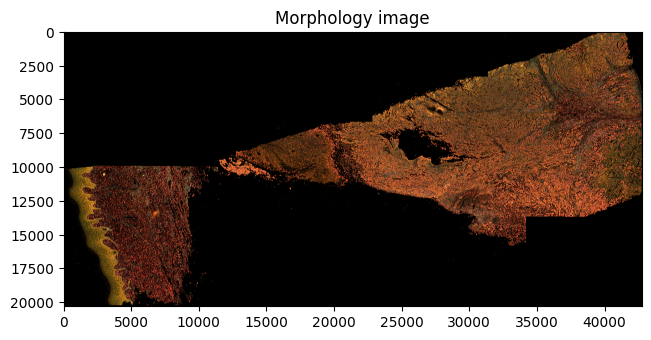

In [41]:
sdata.pl.render_images("morphology_focus").pl.show(title="Morphology image")

INFO     Rasterizing image for faster rendering.                                                                   


Tue Jul  1 14:37:24 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8790003844675125].


INFO     Rasterizing image for faster rendering.                                                                   


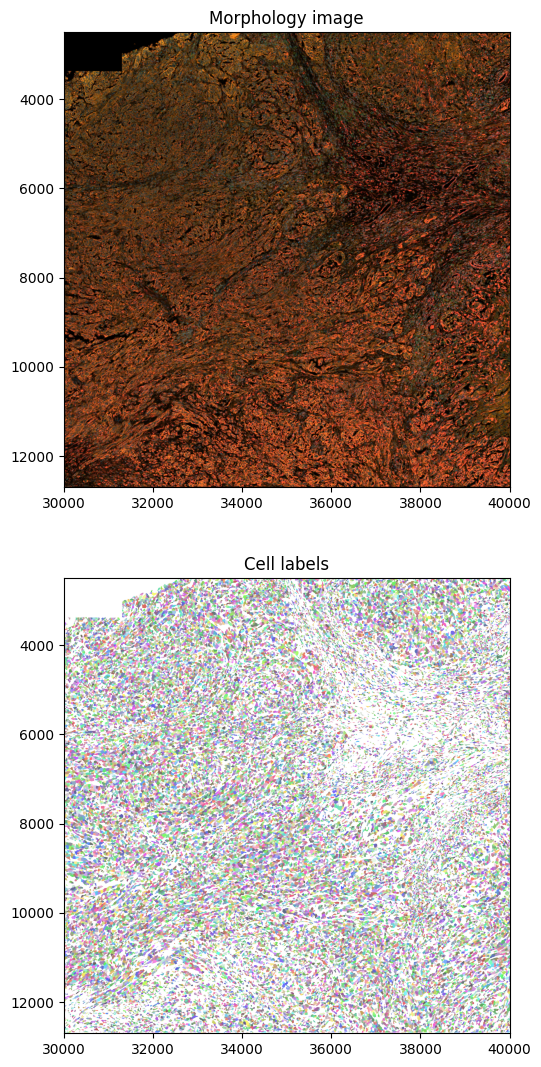

In [ ]:
axes = plt.subplots(2, 1, figsize=(20, 13))[1].flatten()

crop1(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[0], title="Morphology image", coordinate_systems="global"
)
crop1(sdata).pl.render_labels("cell_labels").pl.show(
    ax=axes[1], title="Cell labels", coordinate_systems="global"
)

[autoreload of scprint.model.model failed: Traceback (most recent call last):
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ml4ig1/.local/share/uv/python/cpython-3.12.7-linux-x86_64-gnu/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/ml4

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


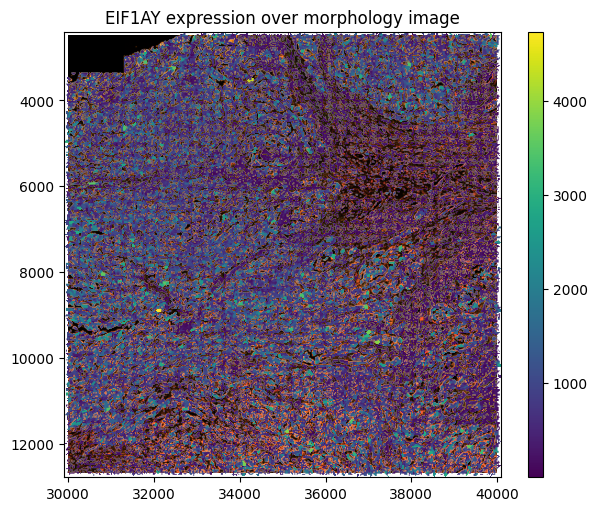

In [ ]:
crop1(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="transcript_counts",
).pl.show(
    title=f"total transcript counts over morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

Tue Jul  1 19:16:03 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


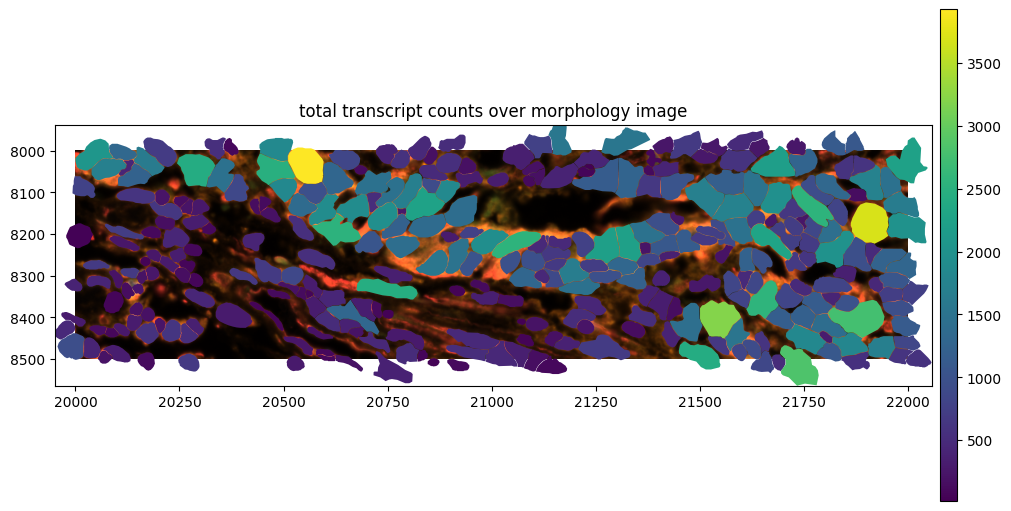

In [ ]:
crop0(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="transcript_counts",
).pl.show(
    title=f"total transcript counts over morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

Tue Jul  1 19:27:46 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


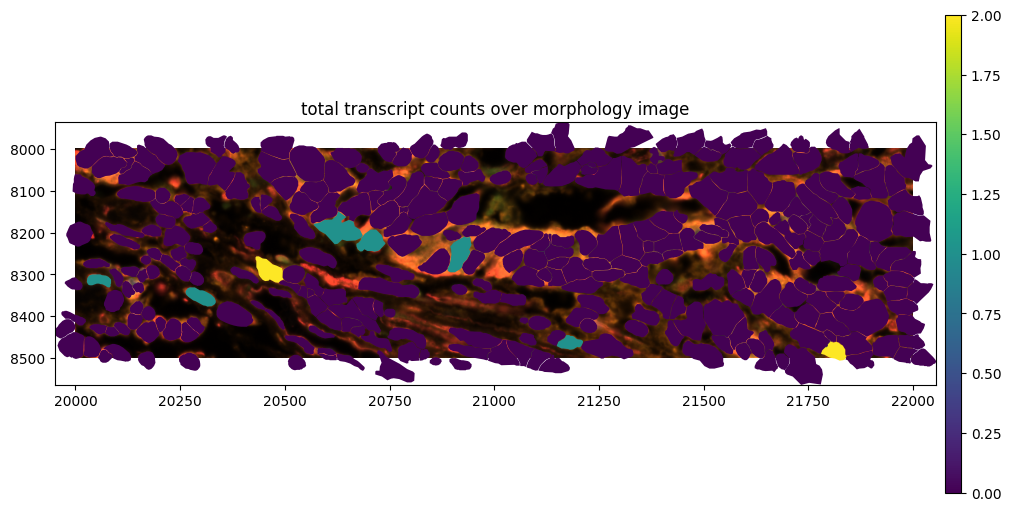

In [ ]:
crop0(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="ABAT",
).pl.show(
    title=f"total transcript counts over morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

# load the model and denoise

In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../w937u4o1.ckpt"

In [3]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

FYI: scPrint is not attached to a `Trainer`.


In [56]:
subsdata = crop0(sdata)
adata = subsdata.tables["table"]
adata

KeyboardInterrupt: 

Wed Jul  2 21:40:47 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


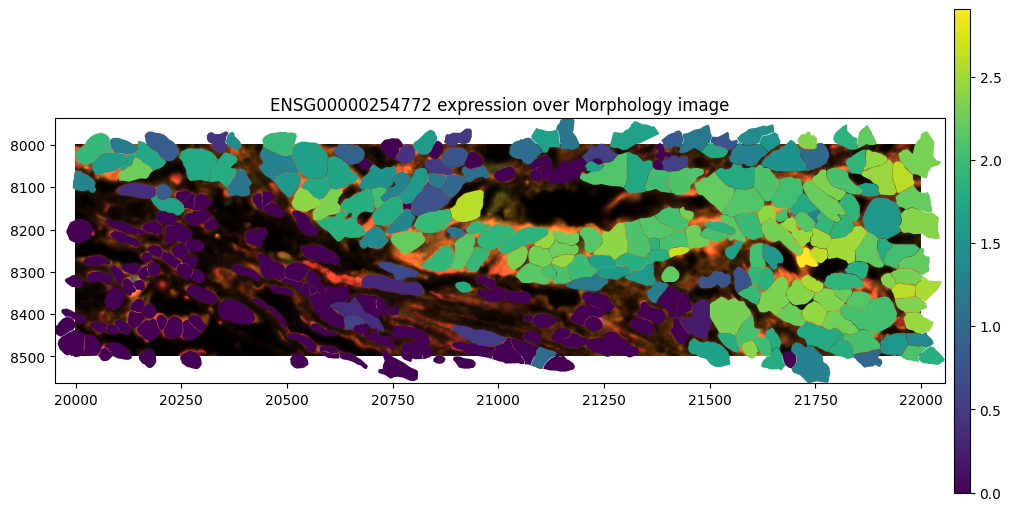

In [ ]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="S100A1",  # "ENSG00000254772",
).pl.show(
    title=f"S100A1 expression over Morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

In [ ]:
adata.var["gene_name"] = adata.var.index
adata.var.index = adata.var["gene_ids"]
adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"

In [ ]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=False,
    min_valid_genes_id=200,
    keepdata=True,
    min_nnz_genes=1,
)
adata = preprocessor(adata.copy())
adata.layers["true"] = adata.X.copy()

checking raw counts
removed 0 non primary cells, 316 renamining
filtered out 0 cells, 316 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 65605 genes in the ontology but not present in the dataset
starting QC
Seeing 39 outliers (12.30% of total dataset):
done
AnnData object with n_obs × n_vars = 316 × 70611
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outl

In [ ]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=30_000,
    doplot=False,
    num_workers=4,
    predict_depth_mult=10,
)
metrics, idx, nadata = denoise(model, adata)
metrics

working on 4929 accepted genes
not on wandb, could not set name


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


logging the anndata


AnnData object with n_obs × n_vars = 316 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [ ]:
nadata = nadata[:, nadata.layers["scprint_mu"].sum(axis=0) > 1]

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

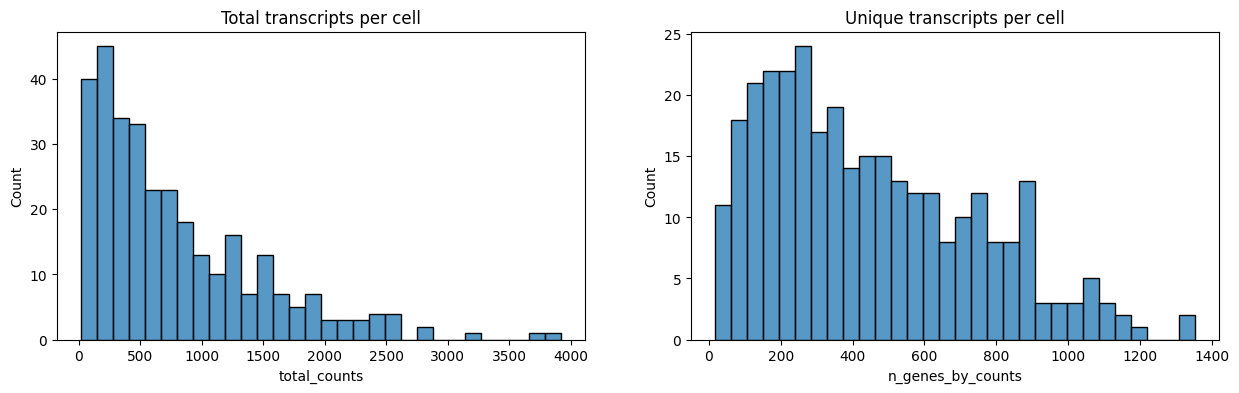

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
    bins=30,  # Increased number of bars
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
    bins=30,  # Increased number of bars
)

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

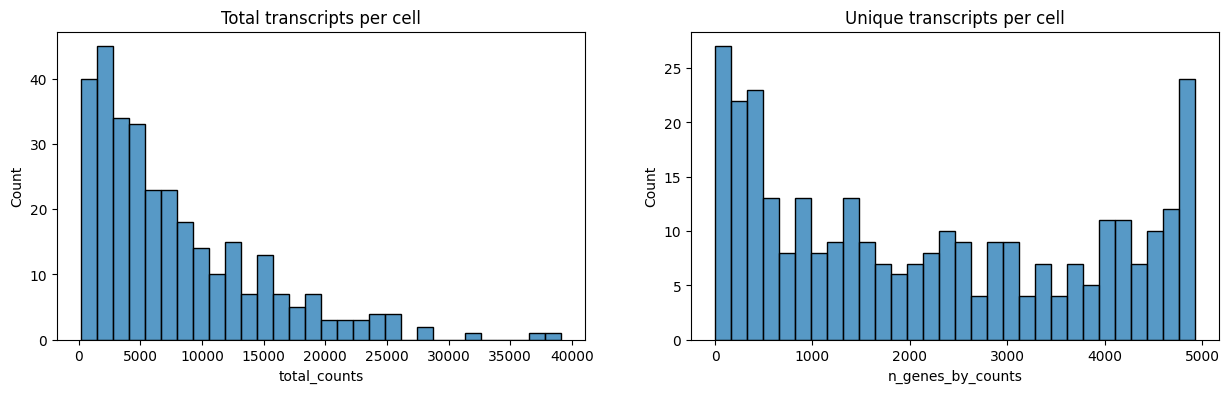

In [13]:
nadata.obs["total_counts"] = nadata.layers["scprint_mu"].sum(axis=1)
nadata.obs["n_genes_by_counts"] = (nadata.layers["scprint_mu"] > 1).sum(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    nadata.obs["total_counts"],
    kde=False,
    ax=axs[0],
    bins=30,  # Increased number of bars
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    nadata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
    bins=30,  # Increased number of bars
)

/tmp/ipykernel_611964/639797741.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(nadata, resolution=1.0)


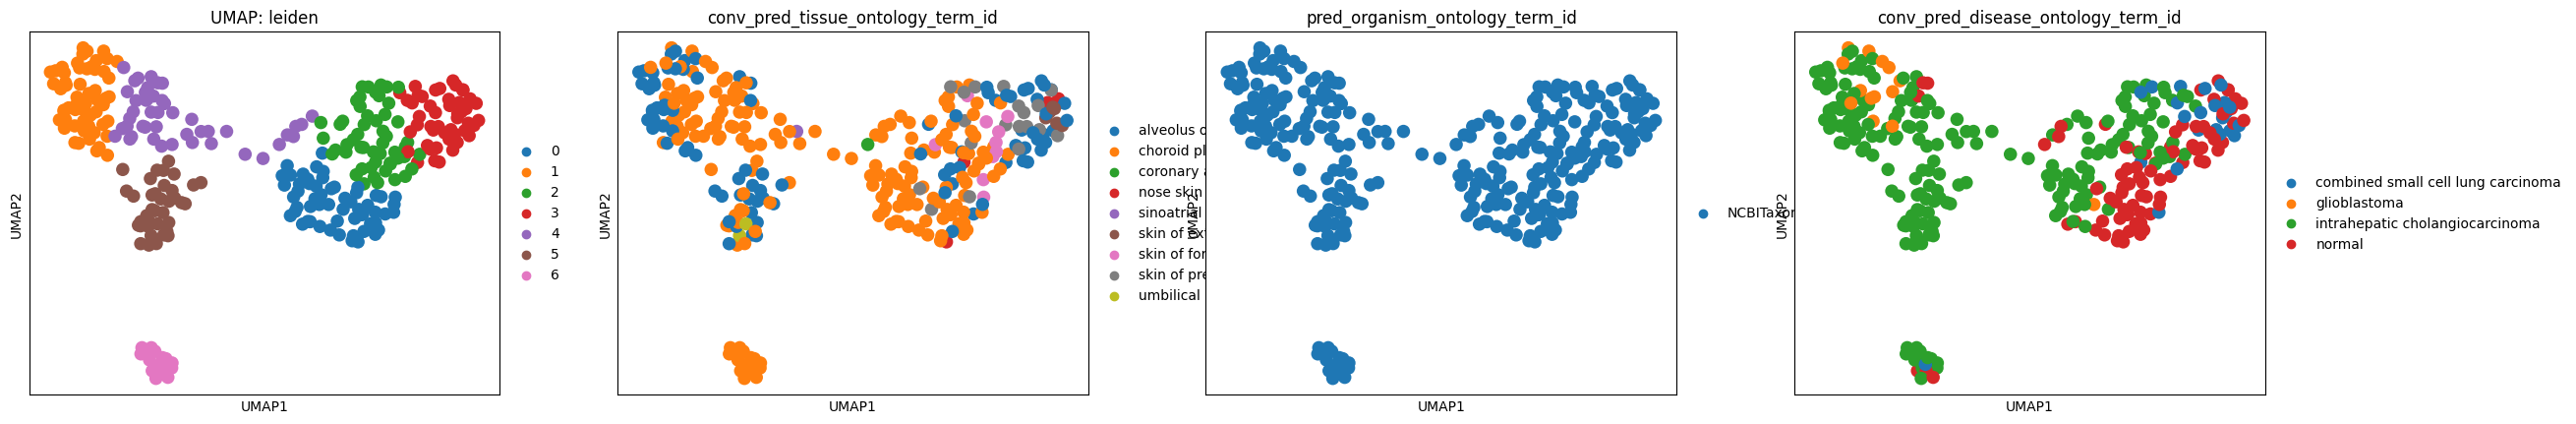

In [ ]:
sc.pp.neighbors(nadata, use_rep="scprint_emb")
sc.tl.leiden(nadata, resolution=1.0)
sc.tl.umap(nadata)
sc.pl.umap(
    nadata,
    color=[
        "leiden",
        "conv_pred_tissue_ontology_term_id",
        "pred_organism_ontology_term_id",
        "conv_pred_disease_ontology_term_id",
    ],
    title="UMAP: leiden",
)

In [15]:
nadata.X = nadata.layers["scprint_mu"].astype(np.int32)

In [16]:
nadata.obs.index = subsdata.tables["table"].obs.index
nadata.obs = pd.concat([nadata.obs, subsdata.tables["table"].obs], axis=1)

In [17]:
subsdata.tables["table"].var.index = subsdata.tables["table"].var.gene_ids

In [33]:
from scipy import sparse

In [ ]:
overlap = set(nadata.var_names) & set(subsdata.tables["table"].var_names)
missing = set(subsdata.tables["table"].var_names) - set(nadata.var_names)
nadata.obs = nadata.obs.loc[:, ~nadata.obs.columns.duplicated()].copy()
nadata = nadata[:, nadata.var_names.isin(overlap)]

zeros = sparse.csr_matrix((nadata.n_obs, len(missing)), dtype=nadata.X.dtype)
gene_stub = AnnData(
    X=zeros, obs=nadata.obs.copy(), var=pd.DataFrame(index=list(missing))
)
nadata = ad.concat((nadata, gene_stub), axis=1, join="outer")
# Reorder nadata to match the ordering of subsdata.tables["table"]
nadata = nadata[:, subsdata.tables["table"].var_names]

nadata.obs = subsdata.tables["table"].obs
nadata.var = subsdata.tables["table"].var


In [35]:
nadata.var.index = nadata.var.gene_name
prevdata = subsdata.tables["table"].copy()
nadata.uns = prevdata.uns

In [ ]:
prevdata.var.index[
    np.array((prevdata.X.sum(0) < 10) & (prevdata.X.sum(0) > 0))[0]
].tolist()

['ABCA3',
 'ABCC3',
 'ABCC9',
 'ABCG2',
 'ABHD11',
 'ABI3BP',
 'ABTB1',
 'ACHE',
 'ACKR3',
 'ACOD1',
 'ACPP',
 'ACRBP',
 'ACVRL1',
 'ADAM28',
 'ADAMTS12',
 'ADAMTS4',
 'ADAMTS5',
 'ADAMTSL3',
 'ADGRA1',
 'ADGRB1',
 'ADGRB2',
 'ADGRE1',
 'ADGRL4',
 'ADORA2A',
 'ADORA2B',
 'ADRA1A',
 'ADRA2A',
 'ADRA2B',
 'ADRA2C',
 'ADRB1',
 'ADRB2',
 'ADTRP',
 'AFAP1L2',
 'AFG1L',
 'AFM',
 'AGER',
 'AGMAT',
 'AGRP',
 'AHRR',
 'ALOX12',
 'ALPK3',
 'ALPL',
 'AMIGO1',
 'AMIGO3',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL2',
 'ANGPTL6',
 'ANGPTL7',
 'ANO1',
 'AOC3',
 'AOX1',
 'AP3B2',
 'APAF1',
 'APCDD1',
 'APLN',
 'APLNR',
 'APOBEC3B',
 'APOBEC3D',
 'APOBEC3F',
 'APOL3',
 'APOM',
 'AQP7',
 'AQP8',
 'AQP9',
 'ARC',
 'ARG2',
 'ARID3B',
 'ARMC5',
 'ARNTL',
 'ARX',
 'ASCL2',
 'ASIC1',
 'ASPN',
 'ATL1',
 'ATP6V1B1',
 'ATP7B',
 'ATXN7L2',
 'AUNIP',
 'AURKC',
 'AVPR1A',
 'AXIN2',
 'BACH2',
 'BAD',
 'BAG2',
 'BAIAP2',
 'BCAM',
 'BCL6B',
 'BDNF',
 'BEAN1',
 'BFSP1',
 'BID',
 'BIK',
 'BLM',
 'BLNK',
 'BMP5',
 'BMP6',
 'BMP8A',

In [67]:
subsdata.tables["table"] = prevdata

In [65]:
gene_name = "MYCL"

Thu Jul  3 14:56:19 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


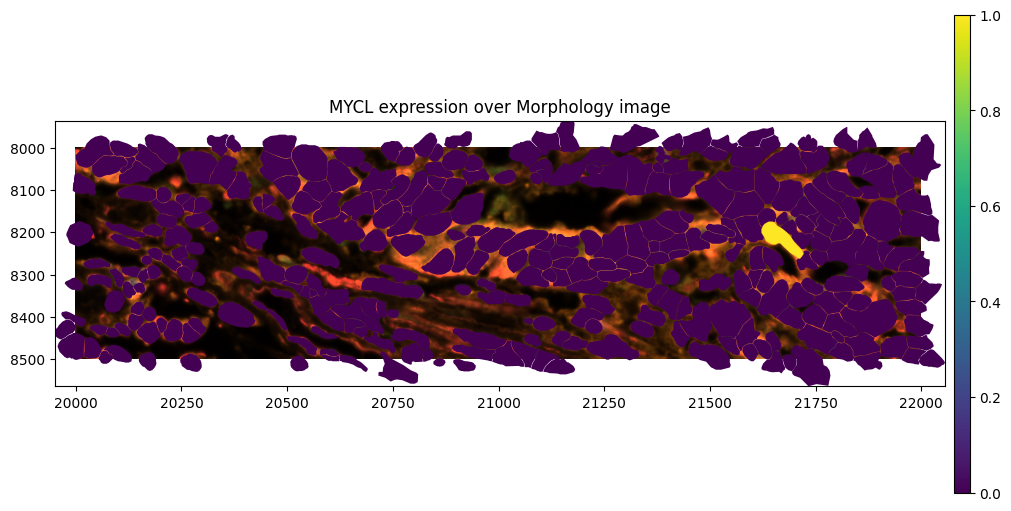

In [ ]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,  # "ENSG00000254772",
).pl.show(
    title=f"{gene_name} expression over Morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

In [ ]:
subsdata.tables["table"] = nadata

Thu Jul  3 14:56:25 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


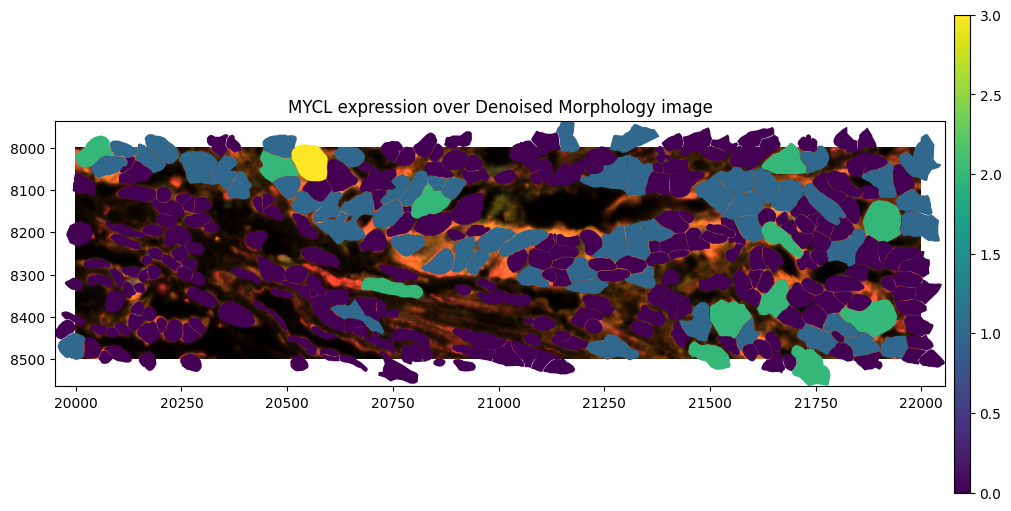

In [ ]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,
).pl.show(
    title=f"{gene_name} expression over Denoised Morphology image",
    coordinate_systems="global",
    figsize=(10, 5),
)

# quantitative

### run on a large fov

In [7]:
subsdata = crop1(sdata)
adata = subsdata.tables["table"]
adata

AnnData object with n_obs × n_vars = 40909 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'log1p', 'hvg'
    obsm: 'spatial'

In [ ]:
adata.X.sum(1).mean(), (adata.X > 0).sum(1).mean()

(185.98064, 343.72891050869003)

## map it with tangram on a dataset

https://github.com/broadinstitute/Tangram

Skin - Right Lower Extremity, Melanoma - dd

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE215121

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=%20GSE120575

In [9]:
# Create data directory for GSE215121
data_dir = Path("../data/GSE215121")
data_dir.mkdir(parents=True, exist_ok=True)
path = Path(data_dir / "GSM6622299_CM1_filtered_feature_bc_matrix.h5")

if path.exists():
    res = sc.read_10x_h5(path)
else:
    # Download the GSE215121 dataset
    url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE215121&format=file"
    filename = data_dir / "GSE215121_RAW.tar"

    print("Downloading GSE215121 data...")
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Downloaded to: {filename}")

    # Extract the tar file
    import tarfile

    print("Extracting tar file...")
    with tarfile.open(filename, "r") as tar:
        tar.extractall(path=data_dir)

In [10]:
res.X.sum(1).mean(), (res.X > 0).sum(1).mean()

(3274.3752, 1014.3406)

In [11]:
# Install required packages for GEO data download
try:
    import tangram as tg
except ImportError:
    import subprocess

    subprocess.check_call(["uv", "pip", "install", "tangram-sc"])
    import tangram as tg

In [12]:
adata.var["gene_names"] = adata.var.index
adata.var.index = adata.var.gene_ids

In [13]:
res.var["gene_names"] = res.var.index
res.var.index = res.var.gene_ids

In [14]:
tg.pp_adatas(res, adata, genes=None)

Tue Aug  5 16:52:29 2025 INFO 4593 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
Tue Aug  5 16:52:29 2025 INFO 4593 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
Tue Aug  5 16:52:29 2025 INFO uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
Tue Aug  5 16:52:29 2025 INFO 4593 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
Tue Aug  5 16:52:29 2025 INFO uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
Tue Aug  5 16:52:29 2025 INFO rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
ad_map = tg.map_cells_to_space(res, adata, device="cuda:0")

Tue Aug  5 16:54:23 2025 INFO Allocate tensors for mapping.
Tue Aug  5 16:54:27 2025 INFO Begin training with 4593 genes and rna_count_based density_prior in cells mode...
Tue Aug  5 16:54:50 2025 INFO Printing scores every 100 epochs.


Score: 0.181, KL reg: 0.030
Score: 0.450, KL reg: 0.004
Score: 0.482, KL reg: 0.003
Score: 0.493, KL reg: 0.002
Score: 0.499, KL reg: 0.002
Score: 0.503, KL reg: 0.002
Score: 0.506, KL reg: 0.002
Score: 0.508, KL reg: 0.002
Score: 0.509, KL reg: 0.002
Score: 0.510, KL reg: 0.002


Tue Aug  5 17:02:58 2025 INFO Saving results..


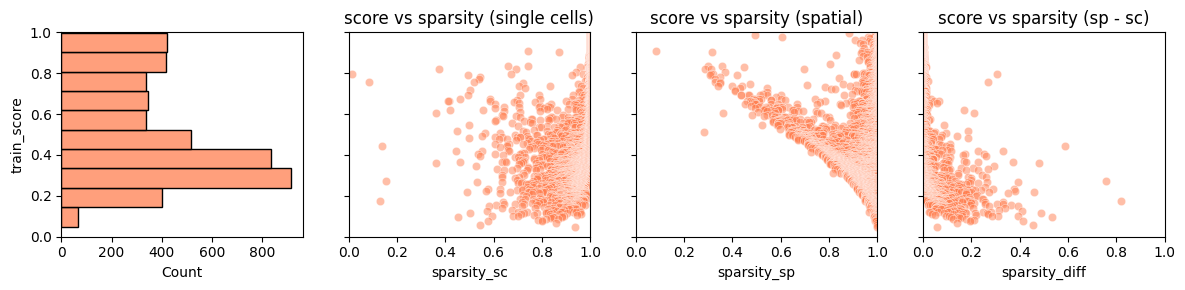

In [ ]:
tg.plot_training_scores(ad_map, bins=10, alpha=0.5)

In [18]:
ad_ge = tg.project_genes(ad_map, res)

In [32]:
ad_ge.X.sum(1).mean(), (ad_ge.X > 0).sum(1).mean()

(800.4046, 22226.0)

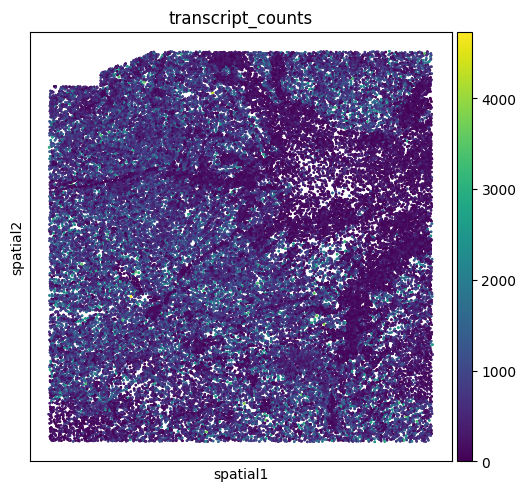

In [29]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "transcript_counts",
    ],
    wspace=0.4,
)

In [ ]:
ad_ge.obsm["spatial"] = adata.obsm["spatial"].copy()

In [42]:
(ad_ge.X > 0.1).sum(1).mean()

904.3657874795277

In [50]:
sc.pp.pca(ad_ge)
sc.pp.neighbors(ad_ge)
sc.tl.umap(ad_ge)
sc.tl.leiden(ad_ge)

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

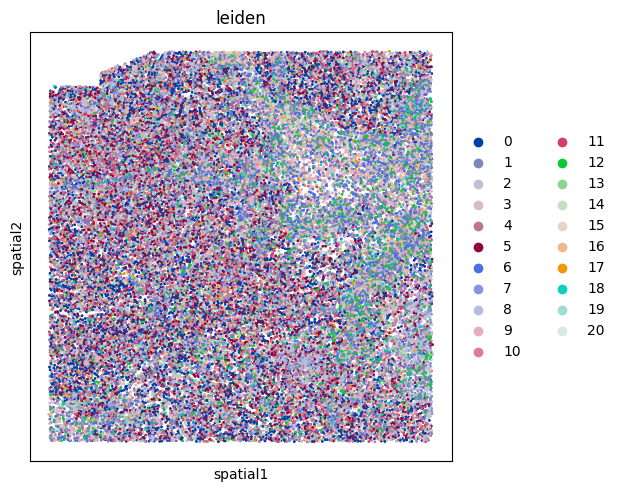

In [51]:
sq.pl.spatial_scatter(
    ad_ge,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

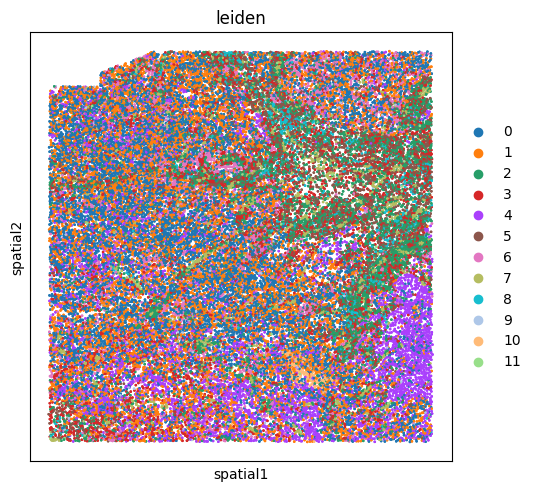

In [52]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

In [53]:
ad_ge.write_h5ad("../data/xenium_subset_mapped.h5ad")
adata.write_h5ad("../data/xenium_subset_adata.h5ad")

In [4]:
adata = ad.read_h5ad("../data/xenium_subset_adata.h5ad")

### compare magic and scprint on same fov

In [5]:
adata.var.index = adata.var["gene_ids"]
adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"

In [6]:
adata.X = adata.raw.X[:, np.array(adata.raw.X.sum(0) != 0)[0]]
del adata.raw
del adata.varm

In [7]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=False,
    min_valid_genes_id=200,
    keepdata=True,
    min_nnz_genes=1,
)
padata = preprocessor(adata.copy())

checking raw counts


removed 0 non primary cells, 40909 renamining
filtered out 1 cells, 40908 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 65606 genes in the ontology but not present in the dataset
starting QC
Seeing 3795 outliers (9.28% of total dataset):
done
AnnData object with n_obs × n_vars = 40908 × 70611
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'uniform_density', 'rna_count_based_density', 'leiden', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_count

In [8]:
denoise = Denoiser(
    batch_size=32,
    max_len=5000,
    how="most var",
    max_cells=50_000,
    save_every=20_000,
    doplot=False,
    num_workers=10,
    predict_depth_mult=10,
)
_, idx, nadata = denoise(model, padata)

working on 4970 accepted genes
not on wandb, could not set name


 49%|████▉     | 625/1279 [12:54<13:57,  1.28s/it]

logging
logging the anndata
AnnData object with n_obs × n_vars = 20032 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scpr

 98%|█████████▊| 1251/1279 [28:45<00:39,  1.40s/it] 

logging
logging the anndata
AnnData object with n_obs × n_vars = 20032 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scpr

100%|██████████| 1279/1279 [31:21<00:00,  1.47s/it]


logging the anndata
AnnData object with n_obs × n_vars = 844 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [9]:
nadata.write_h5ad("../data/xenium_denoised_adata.h5ad")

In [10]:
nadata

View of AnnData object with n_obs × n_vars = 40908 × 4970
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_cell_culture', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_tissue_ontology_term_id'
    layers: 'scprint_mu', 'scprint_pi', 'scprint_theta'

In [16]:
del nadata.obsm

In [49]:
ad_ge = ad.read_h5ad("../data/xenium_subset_mapped.h5ad")
ad_ge.var.index = ad_ge.var.gene_ids

In [ ]:
nadata = nadata[:, nadata.var.index.isin(ad_ge.var.index)]
ad_ge = ad_ge[adata.X.sum(1) >= 1, ad_ge.var.index.isin(nadata.var.index)]
ad_ge = ad_ge[:, ad_ge.var.index.sort_values().values]
adata = padata[:, padata.var.index.isin(ad_ge.var.index)]
if idx is not None:
    ad_ge = ad_ge[idx]
    adata = adata[idx]
adata

IndexError: Unknown indexer None of type <class 'NoneType'>

## on genes that we know about

In [38]:
reco_scprint = (
    nadata[:, nadata.var.index.isin(adata.var.index)]
    .layers["scprint_mu"]
    .multiply(
        (
            F.sigmoid(
                torch.Tensor(
                    nadata[:, nadata.var.index.isin(adata.var.index)]
                    .layers["scprint_pi"]
                    .todense()
                )
            )
            < 0.5
        ).numpy()
    )
    .tocsr()
)

In [39]:
denoised_adata = sc.external.pp.magic(
    adata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
)

reco_magic = denoised_adata.X
true = true = ad_ge[:, ad_ge.var.index.isin(adata.var.index)].X
noisy = adata.X
corr_coef, p_value = spearmanr(
    np.vstack([reco_scprint[true != 0], reco_magic[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco_scprint2noisy": corr_coef[0, 2],
    "reco_magic2noisy": corr_coef[1, 2],
    "reco_scprint2magic": corr_coef[0, 1],
    "reco_scprint2full": corr_coef[0, 3],
    "reco_magic2full": corr_coef[1, 3],
    "noisy2full": corr_coef[2, 3],
}

Calculating MAGIC...
  Running MAGIC on 40908 cells and 4572 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 59.94 seconds.
    Calculating affinities...
    Calculated affinities in 60.66 seconds.
  Calculated graph and diffusion operator in 130.26 seconds.
  Calculating imputation...
  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 133.50 seconds.


{'reco_scprint2noisy': 0.4611114919810298,
 'reco_magic2noisy': 0.364277121357796,
 'reco_scprint2magic': 0.7157635388785792,
 'reco_scprint2full': 0.5813850851162159,
 'reco_magic2full': 0.6481798436313776,
 'noisy2full': 0.26948729719836145}

### on genes that we don't know about: diff expr again predicted cell types

In [24]:
nadata.obs["pred_organism_ontology_term_id"].value_counts()

pred_organism_ontology_term_id
NCBITaxon:9606    40908
Name: count, dtype: int64

In [34]:
nadata.obs["simple_disease"] = nadata.obs["conv_pred_disease_ontology_term_id"].replace({"normal": "normal",
"intrahepatic cholangiocarcinoma": "cancer",
"combined small cell lung carcinoma": "cancer",
"glioblastoma": "cancer",
"tongue squamous cell carcinoma": "cancer",
"olfactory neuroblastoma": "cancer",
"lung adenocarcinoma": "cancer",
"Alzheimer disease": "normal",
"clear cell renal carcinoma": "cancer",
"breast ductal adenocarcinoma": "cancer",
"non-small cell squamous lung carcinoma": "cancer",
"hepatoblastoma": "cancer",
"thyroid gland undifferentiated (anaplastic) carcinoma": "cancer"})

/tmp/ipykernel_1395306/3129876370.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  nadata.obs["simple_disease"] = nadata.obs["conv_pred_disease_ontology_term_id"].replace({"normal": "normal",


In [26]:
nadata.obs["conv_pred_disease_ontology_term_id"].value_counts()

conv_pred_disease_ontology_term_id
normal                                                   18875
intrahepatic cholangiocarcinoma                          16639
combined small cell lung carcinoma                        4441
glioblastoma                                               546
tongue squamous cell carcinoma                             170
olfactory neuroblastoma                                    121
lung adenocarcinoma                                         46
Alzheimer disease                                           29
clear cell renal carcinoma                                  18
breast ductal adenocarcinoma                                10
non-small cell squamous lung carcinoma                       8
hepatoblastoma                                               4
thyroid gland undifferentiated (anaplastic) carcinoma        1
Name: count, dtype: int64

In [27]:
nadata.obs["conv_pred_age_group"].value_counts()

conv_pred_age_group
60-79 year-old stage         22527
fetal stage                  15854
newborn stage (0-28 days)     2461
middle aged stage               29
young adult stage               19
juvenile stage (5-14 yo)        12
child stage (1-4 yo)             6
Name: count, dtype: int64

In [28]:
nadata.obs["conv_pred_assay_ontology_term_id"].value_counts()

conv_pred_assay_ontology_term_id
10x 5' v2               19663
Drop-seq                10275
10x 3' v3                8742
10x multiome             1570
10x immune profiling      363
microwell-seq             210
sci-Plex                   85
Name: count, dtype: int64

In [29]:
nadata.obs["conv_pred_self_reported_ethnicity_ontology_term_id"].value_counts()

conv_pred_self_reported_ethnicity_ontology_term_id
European American    27849
Han Chinese          13059
Name: count, dtype: int64

In [30]:
nadata.obs["pred_sex_ontology_term_id"].value_counts()

pred_sex_ontology_term_id
PATO:0000384    35520
PATO:0000383     5388
Name: count, dtype: int64

In [25]:
nadata.obsm= adata.obsm

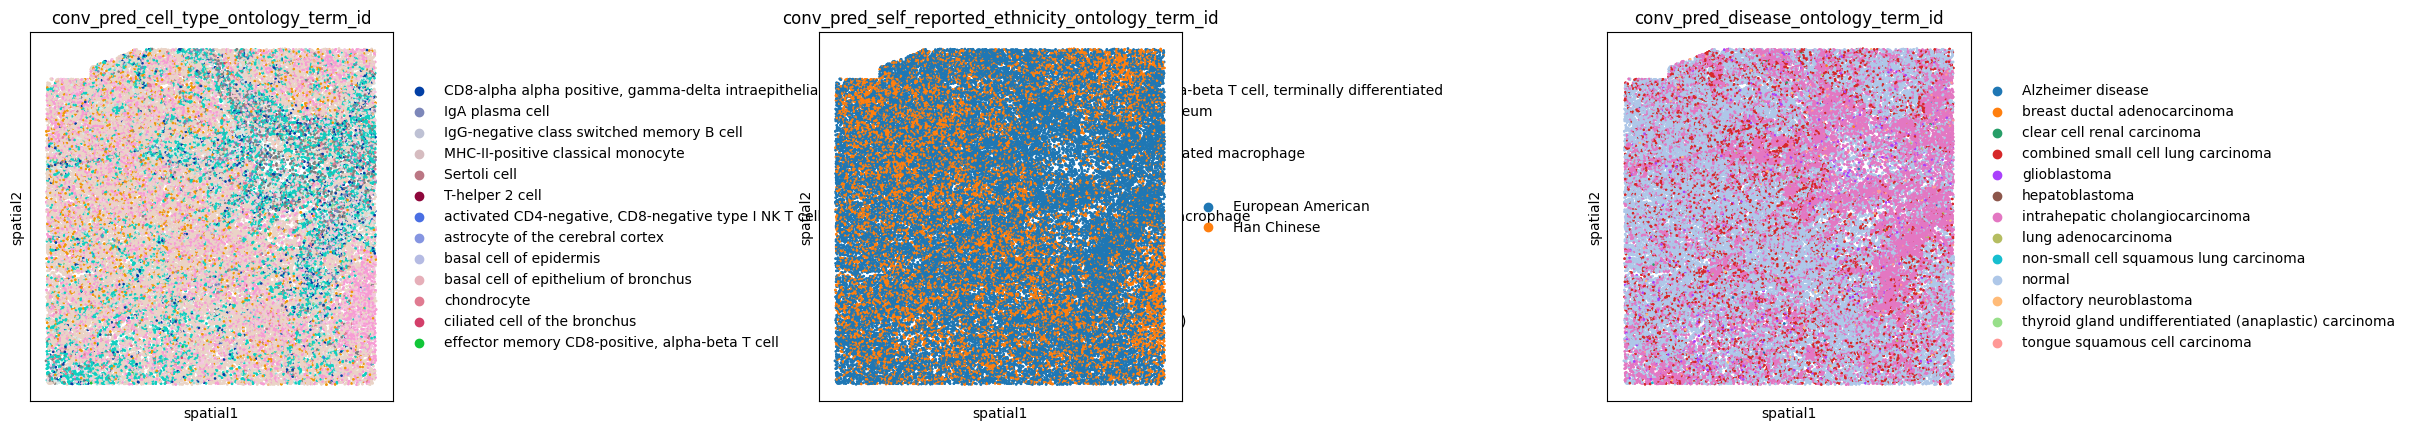

In [33]:
sq.pl.spatial_scatter(
    nadata,
    library_id="spatial",
    shape=None,
    color=[
        "conv_pred_cell_type_ontology_term_id",
        "conv_pred_self_reported_ethnicity_ontology_term_id",
        "conv_pred_disease_ontology_term_id",
    ],
    wspace=0.4,
)

In [55]:
ad_ge = ad.read_h5ad("../data/xenium_subset_mapped.h5ad")
ad_ge.var.index = ad_ge.var.gene_names

In [47]:
"SLC25A15" in adata.var.symbol.tolist()

False

In [66]:
adata.var.index = adata.var.symbol

In [61]:
"BCL2" in ad_ge.var.index.tolist()

True

In [70]:
adata.obs['simple_disease'] = nadata.obs['simple_disease'].tolist()

In [75]:
aggregate_expr

matrix([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Available genes: ['BCL2', 'IGF1', 'EGFR', 'FGFR2']


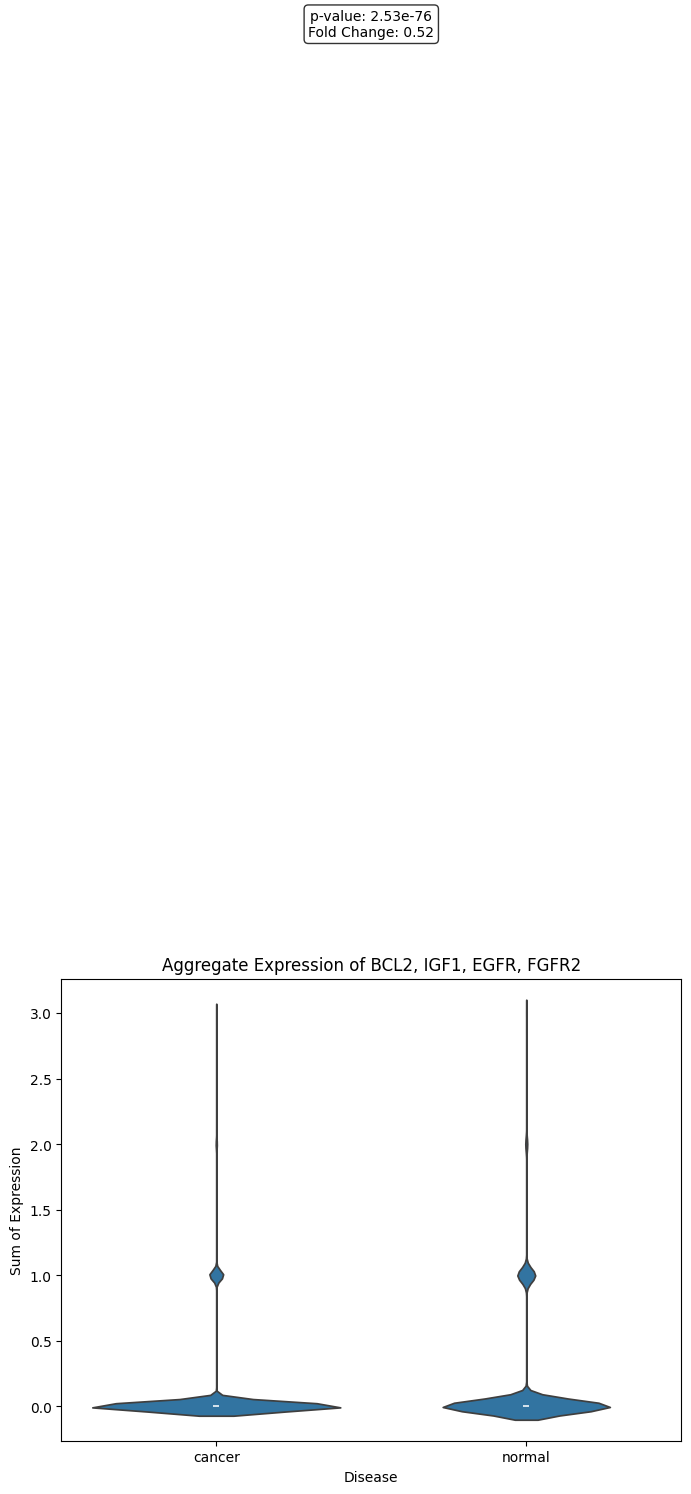

Cancer mean: 0.062
Normal mean: 0.119
Fold change (cancer/normal): 0.519
P-value: 2.531e-76


In [76]:
# Define genes of interest
genes_of_interest = ['BCL2', 'IGF1', 'EGFR', 'FGFR2']

# Check which genes are available in the data
available_genes = [gene for gene in genes_of_interest if gene in adata.var.index]
print(f"Available genes: {available_genes}")

# Calculate aggregate expression (sum of all genes)
if len(available_genes) > 0:
    # Get expression data for available genes
    gene_expr = adata[:, available_genes].X
    
    # Calculate sum across genes (axis=1) and flatten to 1D
    if hasattr(gene_expr, 'A1'):  # For sparse matrices
        aggregate_expr = gene_expr.sum(axis=1).A1
    else:  # For dense arrays
        aggregate_expr = gene_expr.sum(axis=1).ravel()
    
    # Create dataframe for plotting
    df_agg = pd.DataFrame({
        'Aggregate Expression': np.array(aggregate_expr)[0],
        'Disease': adata.obs['simple_disease']
    })
    
    # Calculate statistics
    from scipy.stats import mannwhitneyu
    
    # Separate groups
    cancer_expr = df_agg[df_agg['Disease'] == 'cancer']['Aggregate Expression']
    normal_expr = df_agg[df_agg['Disease'] == 'normal']['Aggregate Expression']
    
    # Calculate p-value (Mann-Whitney U test)
    statistic, pvalue = mannwhitneyu(cancer_expr, normal_expr, alternative='two-sided')
    
    # Calculate fold change
    cancer_mean = cancer_expr.mean()
    normal_mean = normal_expr.mean()
    fold_change = cancer_mean / normal_mean if normal_mean != 0 else np.inf
    
    # Create violin plot
    plt.figure(figsize=(8, 6))
    ax = sns.violinplot(data=df_agg, x='Disease', y='Aggregate Expression')
    
    # Add statistical annotations
    plt.text(0.5, plt.ylim()[1] * 0.95, f'p-value: {pvalue:.2e}\nFold Change: {fold_change:.2f}', 
             ha='center', va='top', transform=ax.transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title(f'Aggregate Expression of {", ".join(available_genes)}')
    plt.ylabel('Sum of Expression')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Cancer mean: {cancer_mean:.3f}")
    print(f"Normal mean: {normal_mean:.3f}")
    print(f"Fold change (cancer/normal): {fold_change:.3f}")
    print(f"P-value: {pvalue:.3e}")

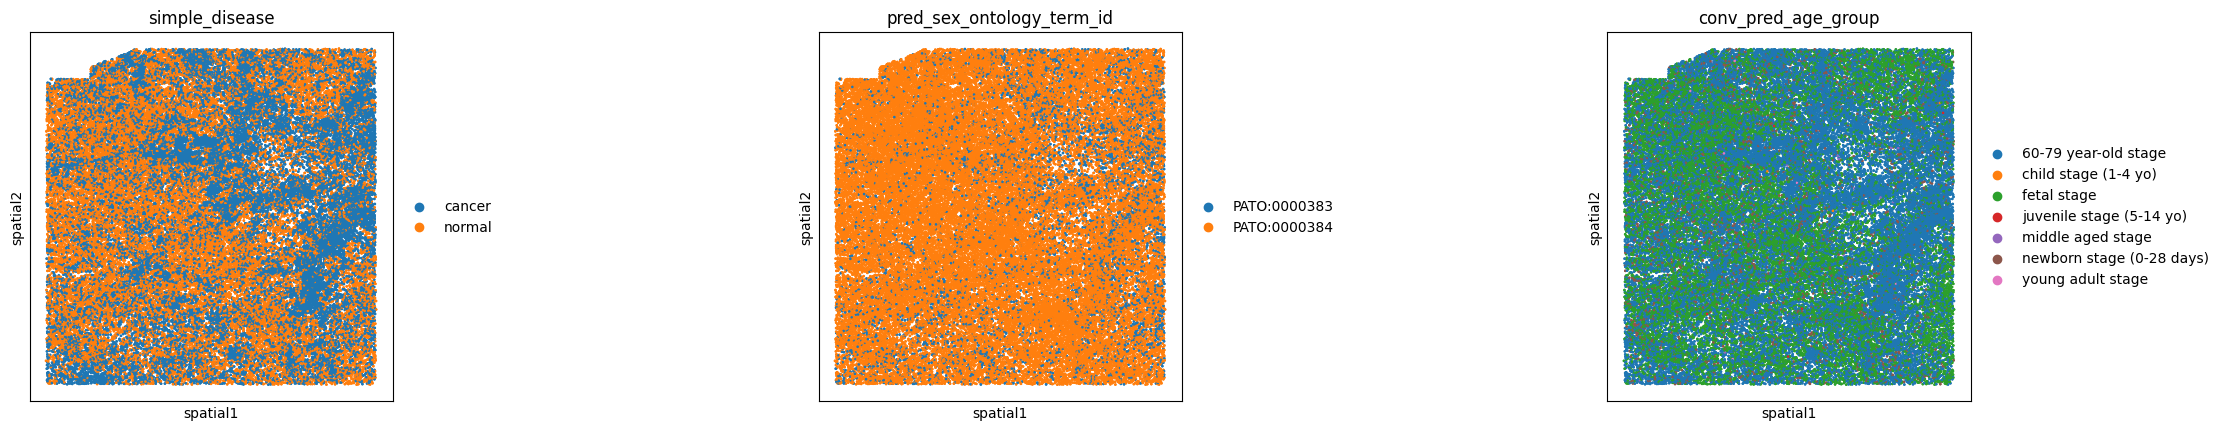

In [35]:
sq.pl.spatial_scatter(
    nadata,
    library_id="spatial",
    shape=None,
    color=[
        "simple_disease",
        "pred_sex_ontology_term_id",
        "conv_pred_age_group",
    ],
    wspace=0.4,
)